In [1]:
# -----All of this data was extracted from IPUMS CPS ----

#Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, 
#J. Robert Warren, Daniel Backman, 
#Annie Chen, Grace Cooper, 
#Stephanie Richards,
#Megan Schouweiler, and Michael Westberry. 
#IPUMS CPS: Version 11.0 [dataset]. Minneapolis, MN: IPUMS, 2023. https://doi.org/10.18128/D030.V11.0
# This is a trial. NONE OF THIS IS TO BE TAKEN AS ACCURATE
# If you are associated with any of the data I extracted and want me to take it down,
#I will take it down and I sincerly apoligize
# if any of this is misrepresented poorly


In [2]:
# EDA, Data Cleaning, Pre-processing, importing libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv('C:/ML/python/data/LaborDemand.csv',delimiter=',',nrows=10000)

df.isna().sum()

print(df.dtypes)

df.describe()
df['SEX'].nunique()
df['SEX'].value_counts()

df['PAIDHOUR'].nunique()


df['SEX'] = pd.get_dummies(df.SEX,prefix='SEX').iloc[:,0:1]

df['RACE'].value_counts()


education_mapping = {'Less than High School':0,'High School':1,'Some College':2,'College':3}
df['EDUC'] = df['EDUC'].map(education_mapping)

race_mapping = {'white':0,'Black':1,'Asian':2,'other':3}
df['RACE'] = df['RACE'].map(race_mapping)
df['RACE'].nunique()
low_wage_df = df[df['Low_Wage_Worker'] == 1]


YEAR                 int64
SEX                  int64
AGE                  int64
RACE                object
HISPAN               int64
PAIDHOUR             int64
EARNWEEK           float64
HOURWAGE           float64
UHRSWORK1            int64
EDUC                object
EARNWT             float64
Low_Wage_Worker      int64
dtype: object


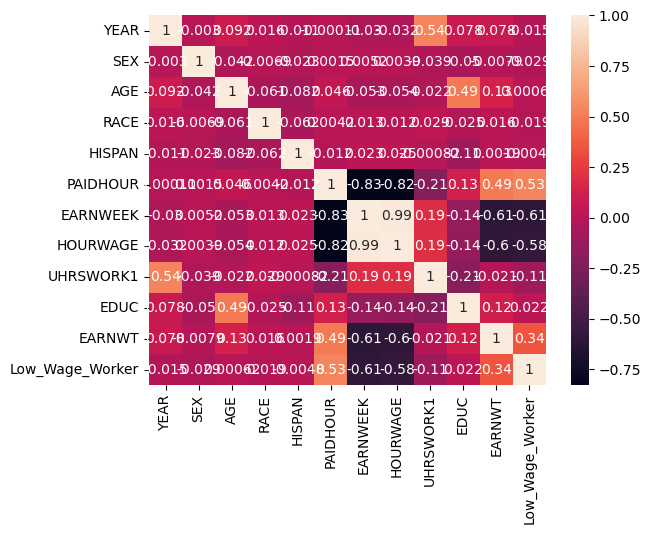

In [3]:
# Correlation heatmap

import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(df.corr(), annot=True)
plt.show()

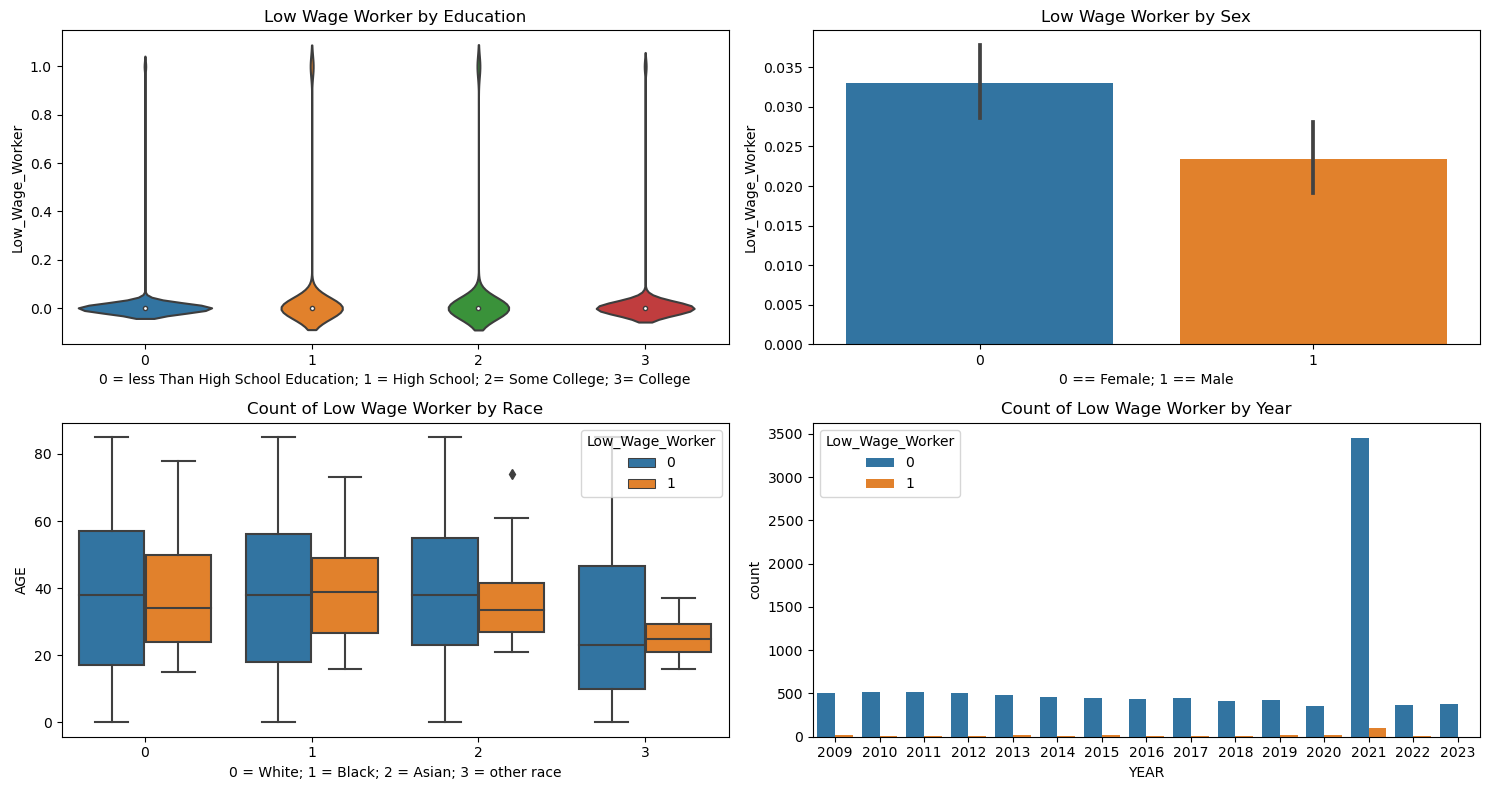

In [4]:
# Visuals of Descriptive Statistics


def subplots(df):
    _, axs = plt.subplots(2,2,figsize=(15,8))
    sns.violinplot(x='EDUC',y='Low_Wage_Worker',ax=axs[0,0],data=df)
    axs[0,0].set_xlabel('0 = less Than High School Education; 1 = High School; 2= Some College; 3= College')
    axs[0,0].set_title('Low Wage Worker by Education')
    sns.barplot(x='SEX', y='Low_Wage_Worker',ax=axs[0,1],data=df)
    axs[0,1].set_title('Low Wage Worker by Sex')
    axs[0,1].set_xlabel('0 == Female; 1 == Male')
    sns.boxplot(x='RACE',y='AGE',hue='Low_Wage_Worker', ax=axs[1,0],data=df)
    axs[1,0].set_title('Count of Low Wage Worker by Race')
    axs[1,0].set_xlabel('0 = White; 1 = Black; 2 = Asian; 3 = other race')
    sns.countplot(x='YEAR',hue='Low_Wage_Worker', ax=axs[1,1],data=df)
    axs[1,1].set_title('Count of Low Wage Worker by Year')
    plt.tight_layout()

subplots(df)




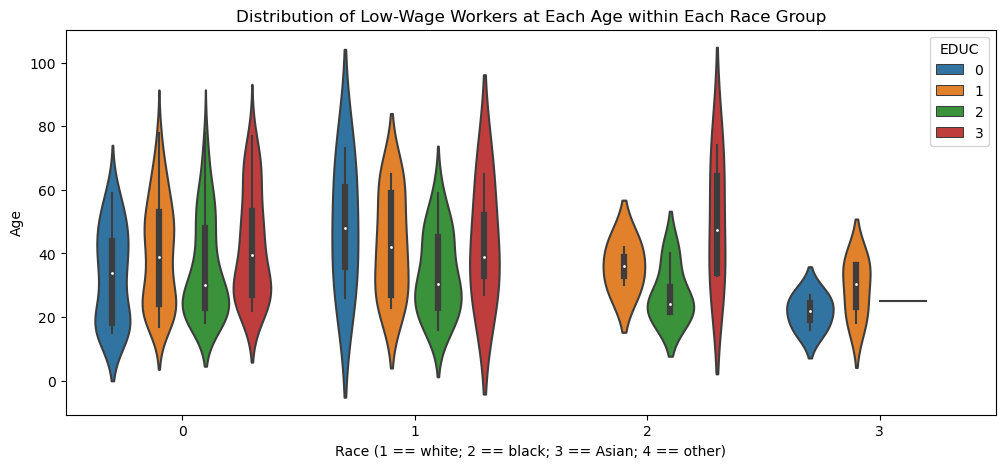

In [5]:
plt.figure(figsize=(12,5))
sns.violinplot(x='RACE',y='AGE',data=low_wage_df,hue='EDUC')
plt.title('Distribution of Low-Wage Workers at Each Age within Each Race Group')
plt.xlabel('Race (1 == white; 2 == black; 3 == Asian; 4 == other)')
plt.ylabel('Age')
plt.show()



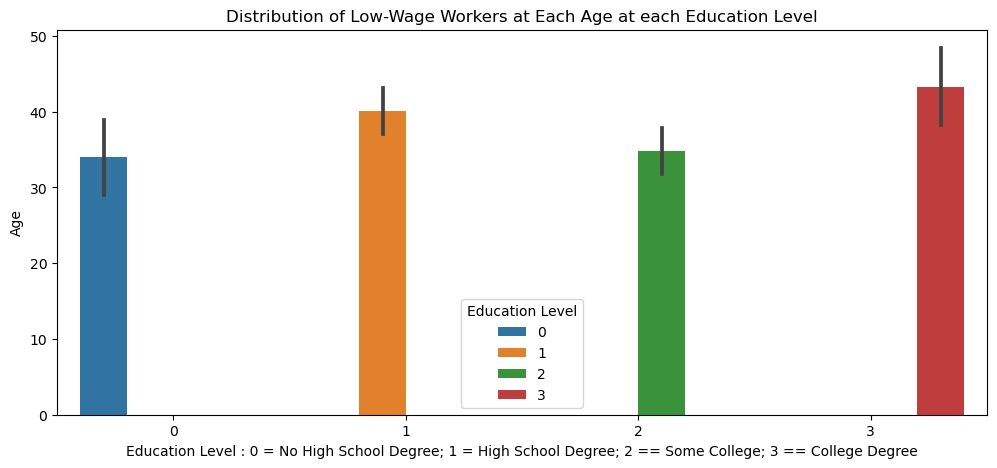

In [6]:
plt.figure(figsize=(12,5))
sns.barplot(x='EDUC',y='AGE',data=low_wage_df,hue='EDUC')
plt.title('Distribution of Low-Wage Workers at Each Age at each Education Level')
plt.xlabel('Education Level : 0 = No High School Degree; 1 = High School Degree; 2 == Some College; 3 == College Degree')
plt.ylabel('Age')
plt.legend(title='Education Level')
plt.show()


In [7]:
import statsmodels.api as sm

#model for race/ethic differences leading to low_wage workforce

X_race = sm.add_constant(df['RACE'])
y_wage = df['Low_Wage_Worker']
model_race = sm.OLS(exog=X_race,endog=y_wage).fit()
print(model_race.summary())


                            OLS Regression Results                            
Dep. Variable:        Low_Wage_Worker   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.457
Date:                Mon, 22 Jan 2024   Prob (F-statistic):             0.0630
Time:                        22:33:55   Log-Likelihood:                 3780.4
No. Observations:               10000   AIC:                            -7557.
Df Residuals:                    9998   BIC:                            -7542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.002     16.247      0.0

In [8]:
# full model. Dependent Variable is Weekly Earnings(EARNWEEK)
X = df.drop(['EARNWEEK','EARNWT'],axis=1)
y = df['EARNWEEK']

full_model = sm.OLS(exog=sm.add_constant(X),endog=y).fit()
print(full_model.summary())


                            OLS Regression Results                            
Dep. Variable:               EARNWEEK   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 4.247e+04
Date:                Mon, 22 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:33:55   Log-Likelihood:                -73543.
No. Observations:               10000   AIC:                         1.471e+05
Df Residuals:                    9989   BIC:                         1.472e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3125.5312   2149.069     

In [9]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)



from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

from sklearn.linear_model import LinearRegression,Ridge,Lasso

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()


from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
BR = BaggingRegressor()


from sklearn.metrics import r2_score,mean_squared_error

def evaluate_model(model,X_train_scaled,X_test_scaled,y_train,y_test):
    model = model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test,pred)
    mse = mean_squared_error(y_test, pred)
    print(f'{model.__class__.__name__}, --R2-- {r2*100:.2f}%; --mse-- {mse:.2f}')
    return pred


lr_pred = evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test)
ridge_pred = evaluate_model(ridge, X_train_scaled, X_test_scaled, y_train, y_test)
lasso_pred = evaluate_model(lasso, X_train_scaled, X_test_scaled, y_train, y_test)
rfr_pred = evaluate_model(rfr, X_train_scaled, X_test_scaled, y_train, y_test)
BR_pred = evaluate_model(BR, X_train_scaled, X_test_scaled, y_train, y_test)
gbr_pred = evaluate_model(gbr, X_train_scaled, X_test_scaled, y_train, y_test)

LinearRegression, --R2-- 98.92%; --mse-- 68225.20
Ridge, --R2-- 98.92%; --mse-- 68238.78
Lasso, --R2-- 98.92%; --mse-- 68139.39
RandomForestRegressor, --R2-- 99.74%; --mse-- 16518.54
BaggingRegressor, --R2-- 99.64%; --mse-- 22577.78
GradientBoostingRegressor, --R2-- 99.41%; --mse-- 37373.26
